# Chapter 3: From Data to Networks

In [1]:
# Configure plotting in Jupyter
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({
    'figure.figsize': (7.5, 7.5),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})
# Seed random number generator
from numpy import random as nprand
import random
seed = hash("Network Science in Python") % 2**32
nprand.seed(seed)
random.seed(seed)

In [2]:
import networkx as nx

## Reading and Writing Network Files
### Edge list

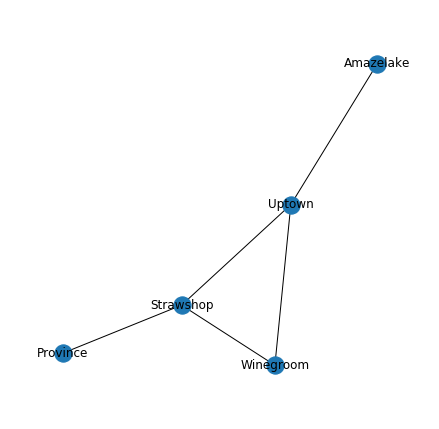

In [3]:
# Create data directory path
from pathlib import Path
data_dir = Path('.') / 'data'
# Read edge list
G = nx.read_edgelist(data_dir / 'example.edgelist')
# Draw network
ax = plt.subplot(111)
nx.draw_networkx(G)
ax.margins(0.15, 0.15)

### Directed edge list

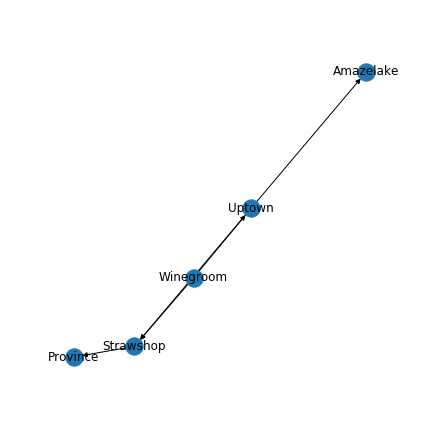

In [4]:
# Read edge list
G = nx.read_edgelist(
    data_dir / 'example.edgelist',
    create_using=nx.DiGraph)
# Draw network
ax = plt.subplot(111)
nx.draw_networkx(G)
ax.margins(0.15, 0.15)

### Weighted edge list

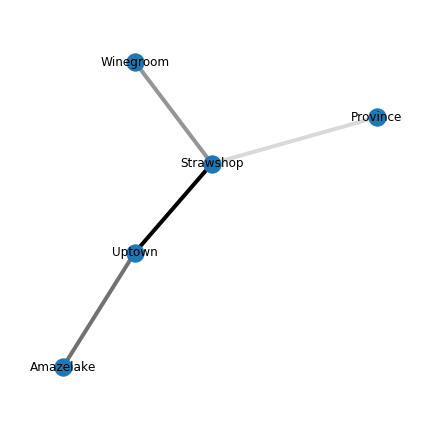

In [5]:
# Read edge list
G = nx.read_weighted_edgelist(
    data_dir / 'weighted.edgelist')
# Extract weights
weights = [d['weight'] for s, t, d in G.edges(data=True)]
# Draw network
ax = plt.subplot(111)
nx.draw_networkx(
    G, width=4, edge_color=weights, edge_cmap=plt.cm.Greys)
ax.margins(0.15, 0.15)

### Edge list with edge attributes

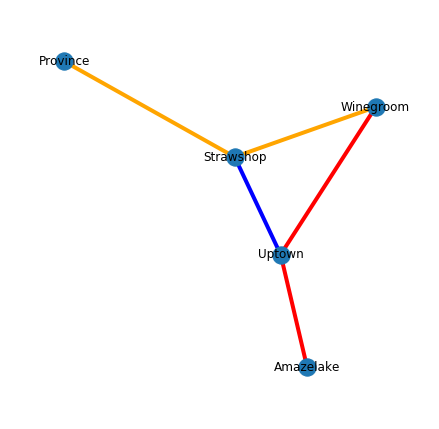

In [6]:
# Read edge list
G = nx.read_edgelist(
    data_dir / 'attributes.edgelist',
    data=[('weight', float), ('color', str)])
# Extract colors
colors = [d['color'] for s, t, d in G.edges(data=True)]
# Draw network
ax = plt.subplot(111)
nx.draw_networkx(
    G, width=4, edge_color=colors)
ax.margins(0.15, 0.15)

### Adjacency list

In [7]:
# Read adjacency list
G_adj = nx.read_adjlist(data_dir / 'example.adjlist')

### GEXF

In [8]:
for v in G.nodes:
    G.nodes[v]['abbreviation'] = v[0]
import sys
nx.write_gexf(G, sys.stdout)

<?xml version='1.0' encoding='utf-8'?>
<gexf version="1.2" xmlns="http://www.gexf.net/1.2draft" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.w3.org/2001/XMLSchema-instance">
  <graph defaultedgetype="undirected" mode="static" name="">
    <attributes class="edge" mode="static">
      <attribute id="1" title="color" type="string" />
    </attributes>
    <attributes class="node" mode="static">
      <attribute id="0" title="abbreviation" type="string" />
    </attributes>
    <meta>
      <creator>NetworkX 2.2rc1.dev_20190313172730</creator>
      <lastmodified>13/03/2019</lastmodified>
    </meta>
    <nodes>
      <node id="Winegroom" label="Winegroom">
        <attvalues>
          <attvalue for="0" value="W" />
        </attvalues>
      </node>
      <node id="Uptown" label="Uptown">
        <attvalues>
          <attvalue for="0" value="U" />
        </attvalues>
      </node>
      <node id="Strawshop" label="Strawshop">
        <attvalues>

### JSON

In [9]:
nx.node_link_data(G)

{'directed': False,
 'graph': {},
 'links': [{'color': 'red',
   'source': 'Winegroom',
   'target': 'Uptown',
   'weight': 1.0},
  {'color': 'orange',
   'source': 'Winegroom',
   'target': 'Strawshop',
   'weight': 5.0},
  {'color': 'blue', 'source': 'Uptown', 'target': 'Strawshop', 'weight': 9.0},
  {'color': 'red', 'source': 'Uptown', 'target': 'Amazelake', 'weight': 6.0},
  {'color': 'orange',
   'source': 'Strawshop',
   'target': 'Province',
   'weight': 3.0}],
 'multigraph': False,
 'nodes': [{'abbreviation': 'W', 'id': 'Winegroom'},
  {'abbreviation': 'U', 'id': 'Uptown'},
  {'abbreviation': 'S', 'id': 'Strawshop'},
  {'abbreviation': 'A', 'id': 'Amazelake'},
  {'abbreviation': 'P', 'id': 'Province'}]}

## Creating a Network with Code

In [10]:
# Ignore articles, pronouns, etc.
stop_words = set([
    'the', 'of', 'and', 'i', 'to', 'my', 'in', 'was', 'that', 'thy',
    'a', 'had', 'my', 'with', 'but', 'he', 'she', 'you', 'your',
    'me', 'not', 'as', 'will', 'from', 'on', 'be', 'it', 'which',
    'for', 'his', 'him', 'chapter', 'at', 'who', 'by', 'have',
    'would', 'is', 'been', 'when', 'they', 'there', 'we', 'are',
    'our', 'if', 'her', 'were', 'than', 'this', 'what', 'so',
    'yet', 'more', 'their', 'them', 'or', 'could', 'an', 'can',
    'said', 'may', 'do', 'these', 'shall', 'how', 'shall', 'asked',
    'before', 'those', 'whom', 'am', 'even', 'its', 'did', 'then',
    'abbey', 'tintern', 'wordsworth', 'letter', 'thee', 'thou', 'oh',
    'into', 'any', 'myself', 'nor', 'himself', 'one', 'all', 'no', 'yes'
    'now', 'upon', 'only', 'might', 'every', 'own', 'such', 'towards',
    'again', 'most', 'ever', 'where', 'after', 'up', 'soon', 'many',
    'also', 'like', 'over', 'us', 'thus', 'has', 'about']
    + [str(x) for x in range(24)])

In [11]:
# Construct a network from a text
def co_occurrence_network(text):
    import re
    # Create a new network
    G = nx.Graph()
    # Split the text into sentences and iterate through them
    sentences = text.split('.')
    for s in sentences:
        # Remove punctuation and convert to lowercase
        clean = re.sub('[^\w\n ]+', '', s).lower()
        clean = re.sub('_+', '', clean).strip()
        # Create list of words separated by whitespace
        words = re.split('\s+', clean)
        # Create an edge for each pair of words
        for v in words:
            # Update word count, add node if necessary
            try:
                G.nodes[v]['count'] += 1
            except KeyError:
                G.add_node(v)
                G.nodes[v]['count'] = 1
            # Update edge count for each pair of words in this sentence
            for w in words:
                # Skip stop words
                if v == w or v in stop_words or w in stop_words:
                    continue
                # Skip blank space
                if len(v) == 0 or len(w) == 0:
                    continue
                # Add one to the edge's count
                try:
                    G.edges[v, w]['count'] += 1
                except KeyError:
                    # Edge doesn't exist, create it
                    G.add_edge(v, w, count=1)
    return G

In [12]:
# Read the text
with open(data_dir / 'shelley1818' / 'frankenstein.txt') as f:
    text = f.read()
# Create a network from the text
G = co_occurrence_network(text)

In [13]:
pairs = sorted(
    G.edges(data=True),
    key=lambda e: e[2]['count'],
    reverse=True)
pairs[0:10]

[('man', 'old', {'count': 68}),
 ('country', 'native', {'count': 38}),
 ('first', 'now', {'count': 32}),
 ('death', 'life', {'count': 32}),
 ('human', 'being', {'count': 32}),
 ('natural', 'philosophy', {'count': 32}),
 ('eyes', 'tears', {'count': 30}),
 ('first', 'eyes', {'count': 28}),
 ('some', 'time', {'count': 28}),
 ('night', 'during', {'count': 28})]

(-0.1, 0.1)

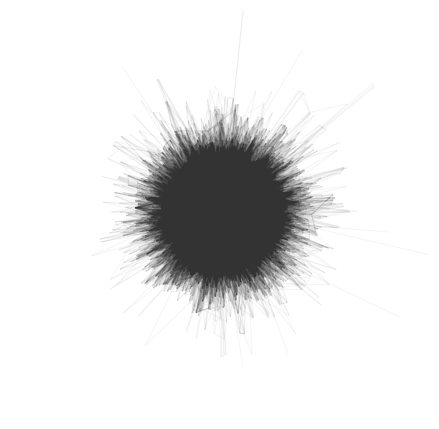

In [14]:
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, alpha=0)
nx.draw_networkx_edges(
    G, pos, edge_color="#333333", alpha=0.05)
# Zoom in for a better view
plt.xlim([-0.1,0.1]); plt.ylim([-0.1, 0.1])

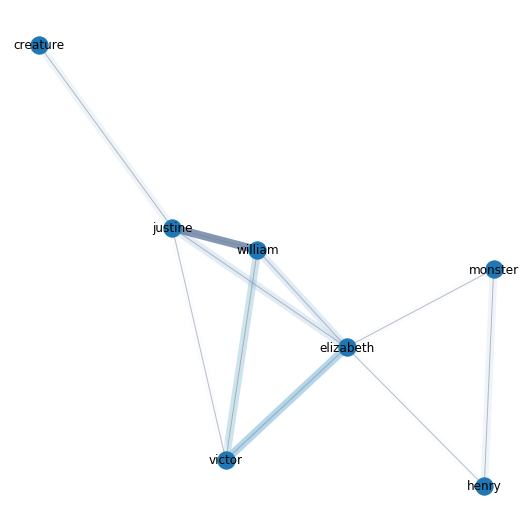

In [15]:
# Count co-occurrences for characters only
characters = [
    'creature', 'monster', 'victor', 'elizabeth',
    'william', 'henry', 'justine']
G_focus = G.subgraph(characters)
# Create list of edge counts
counts = [G_focus.edges[e]['count'] for e in G_focus.edges]

# Create spring layout
pos = nx.spring_layout(G_focus)

# Create figure and draw nodes
plt.figure()
nx.draw_networkx_nodes(G_focus, pos)
# Draw edges
nx.draw_networkx_edges(
    G_focus, pos, width=8,
    edge_color=counts, edge_cmap=plt.cm.Blues, alpha=0.5)
nx.draw_networkx_edges(G_focus, pos, edge_color="#7f7f7f",alpha=0.5)
# Draw labels
nx.draw_networkx_labels(G_focus, pos)
plt.tight_layout()